In [47]:
# Cell 1: Imports and Configuration
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
import matplotlib.pyplot as plt
from ipywidgets import interact, Dropdown, IntSlider, interactive
import ipywidgets as widgets

# Thresholds
MIN_MINUTES_DEFAULT = 45
MIN_SPRINTS_DEFAULT = 5
MIN_RUNS_DEFAULT = 5
MIN_PRESSES_DEFAULT = 8

# Metric family configuration
METRIC_FAMILIES = {
    "Sprints": {
        "metrics": [
            "high_value_sprint_pct",
            "attacking_sprint_pct",
            "defensive_sprint_pct",
            "high_value_sprints_per_90",
            "sprint_distance_per_90"
            ],
        "volume_col": "sprint_count",
        "min_volume_default": MIN_SPRINTS_DEFAULT,
        "primary_rate": "high_value_sprints_per_90"
    },
    "Off-ball runs": {
        "metrics": [
            "avg_xthreat",
            "threat_per_90",
            "high_value_run_pct",
            "high_value_runs_per_90",
            "avg_opponents_beaten"
        ],
        "volume_col": "run_count",
        "min_volume_default": MIN_RUNS_DEFAULT,
        "primary_rate": "threat_per_90"
    },
    "Pressing": {
        "metrics": [
            "press_success_rate",
            "regain_rate",
            "disruption_rate",
            "shot_creation_rate",
            "successful_presses_per_90",
            "pressing_actions_per_90",
        ],
        "volume_col": "pressing_action_count",
        "min_volume_default": MIN_PRESSES_DEFAULT,
        "primary_rate": "successful_presses_per_90"
    },
}

print("✓ Configuration loaded")

✓ Configuration loaded


### Updated KPI selection for visualisation

The metric families used in the visualisation have been updated to focus on
metrics that are:

- tactically meaningful
- position-agnostic where possible
- stable at match-level sample sizes
- aligned with SkillCorner modelling concepts (value, intent, impact)

#### Sprints
Removed `sprints_in_attacking_third_pct` as it behaved inconsistently due to
small denominators and role-specific skew (e.g., CBs only sprint occasionally
and often during set pieces). Added:

- `sprint_distance_per_90` for physical intensity
- `sprints_in_shot_possessions_pct` for value alignment
- kept optional `defensive_sprint_pct` for role orientation

#### Off-ball runs
Selected only the most stable, interpretable KPIs:
- `threat_per_90`
- `high_value_runs_per_90`
Other subtype-based or speed metrics were kept out for clarity.

#### Pressing
Added outcome-based pressing value:
- `shot_creation_rate`  
This captures pressing actions contributing to shot creation and is a strong
indicator of tactical effectiveness.

In [48]:
# Cell 2: Load and clean data
df = pd.read_csv('../output/player_metrics.csv')

# Basic cleaning
df = df.dropna(subset=['player_id', 'player_short_name', 'position_group'])
df = df[df['minutes_played'] >= MIN_MINUTES_DEFAULT].copy()

print(f"Loaded {len(df)} player-match records")
print(f"Unique players: {df['player_short_name'].nunique()}")
print(f"Position groups: {sorted(df['position_group'].unique())}")
print(f"Teams: {sorted(df['team_name'].unique())}")

Loaded 207 player-match records
Unique players: 145
Position groups: ['Center Forward', 'Central Defender', 'Full Back', 'Midfield', 'Other', 'Wide Attacker']
Teams: ['Adelaide United Football Club', 'Auckland FC', 'Brisbane Roar FC', 'Central Coast Mariners Football Club', 'Macarthur FC', 'Melbourne City FC', 'Melbourne Victory Football Club', 'Newcastle United Jets FC', 'Perth Glory Football Club', 'Sydney Football Club', 'Wellington Phoenix FC', 'Western United']


In [49]:
# Cell 3: Helper functions

def get_eligible_players(df, metric_family, min_minutes, min_volume):
    """Filter to players with sufficient minutes and event volume."""
    cfg = METRIC_FAMILIES[metric_family]
    metrics = cfg["metrics"]
    volume_col = cfg["volume_col"]
    
    subset = df.copy()
    subset = subset[subset["minutes_played"] >= min_minutes]
    subset = subset[subset[volume_col] >= min_volume]
    subset = subset.dropna(subset=metrics, how="all")
    
    return subset


def add_percentiles(eligible_df, metric_family, cohort_mode):
    """Add percentile columns for each metric based on cohort grouping."""
    cfg = METRIC_FAMILIES[metric_family]
    metrics = cfg["metrics"]
    df_pct = eligible_df.copy()
    
    # Determine grouping keys
    if cohort_mode == "All players":
        group_keys = None
    elif cohort_mode == "Same position_group":
        group_keys = ["position_group"]
    elif cohort_mode == "Same team":
        group_keys = ["team_name"]
    elif cohort_mode == "Same team and position_group":
        group_keys = ["team_name", "position_group"]
    else:
        raise ValueError("Unknown cohort_mode")
    
    # Compute percentiles
    for m in metrics:
        if group_keys is None:
            ranks = df_pct[m].rank(pct=True)
        else:
            ranks = df_pct.groupby(group_keys)[m].rank(pct=True)
        df_pct[m + "_pctile"] = (ranks * 100).round(1)
    
    return df_pct


def get_comparison_baseline(df_pct, player_row, comparison_target, metric_family):
    """
    Build a comparison baseline (average) based on target type.
    Returns a dict-like row with same structure as player_row.
    
    KEY FIX: For averages, we need to:
    1. Take mean of RAW metric values (not percentiles)
    2. Calculate where that mean sits as a percentile within the cohort
    """
    cfg = METRIC_FAMILIES[metric_family]
    metrics = cfg["metrics"]
    
    if comparison_target == "Position-group average":
        mask = df_pct['position_group'] == player_row['position_group']
        cohort = df_pct[mask]
        label = f"{player_row['position_group']} avg"
        
    elif comparison_target == "Team average":
        mask = df_pct['team_name'] == player_row['team_name']
        cohort = df_pct[mask]
        label = f"{player_row['team_name']} avg"
        
    elif comparison_target == "Team + position-group average":
        mask = (df_pct['position_group'] == player_row['position_group']) & \
               (df_pct['team_name'] == player_row['team_name'])
        cohort = df_pct[mask]
        label = f"{player_row['team_name']} {player_row['position_group']} avg"
    else:
        return None, None
    
    # Build baseline with RAW means
    baseline = {}
    for m in metrics:
        # Mean of raw metric values
        baseline[m] = cohort[m].mean()
        
        # Calculate percentile: where does this mean sit in the cohort distribution?
        raw_values = cohort[m].dropna()
        if len(raw_values) > 0:
            # Count how many values are <= the mean
            pct_below = (raw_values <= baseline[m]).sum() / len(raw_values)
            baseline[m + '_pctile'] = round(pct_below * 100, 1)
        else:
            baseline[m + '_pctile'] = 50.0  # Fallback
    
    return pd.Series(baseline), label

print("✓ Helper functions defined")

✓ Helper functions defined


In [ ]:
# Cell 4: Unified interactive comparison widget

def create_comparison_widget():
    """Main interactive player comparison interface."""
    
    # UI controls
    metric_dropdown = Dropdown(
        options=list(METRIC_FAMILIES.keys()),
        value="Sprints",
        description="Metric:"
    )
    
    cohort_dropdown = Dropdown(
        options=["All players", "Same position_group", "Same team", "Same team and position_group"],
        value="Same position_group",
        description="Cohort:"
    )
    
    position_dropdown = Dropdown(
        options=["All position groups"],
        description="Position:"
    )
    
    min_minutes_slider = IntSlider(
        min=30, max=90, step=15,
        value=MIN_MINUTES_DEFAULT,
        description="Min mins:"
    )
    
    min_volume_slider = IntSlider(
        min=1, max=20, step=1,
        value=MIN_SPRINTS_DEFAULT,
        description="Min volume:"
    )
    
    comparison_dropdown = Dropdown(
        options=["Individual player", "Position-group average", "Team average", 
                "Team + position-group average"],
        value="Individual player",
        description="Compare to:"
    )
    
    player1_dropdown = Dropdown(description="Player 1:")
    player2_dropdown = Dropdown(description="Player 2:")
    
    output = widgets.Output()
    
    def update_filters(*args):
        """Update dependent dropdowns when filters change."""
        metric_family = metric_dropdown.value
        min_minutes = min_minutes_slider.value
        min_volume = min_volume_slider.value
        position_filter = position_dropdown.value
        
        # Update min_volume default
        min_volume_slider.value = METRIC_FAMILIES[metric_family]["min_volume_default"]
        
        # Get eligible players
        eligible = get_eligible_players(df, metric_family, min_minutes, min_volume)
        
        # Update position filter options
        positions = ["All position groups"] + sorted(eligible['position_group'].unique())
        position_dropdown.options = positions
        
        # Apply position filter
        if position_filter != "All position groups" and position_filter in eligible['position_group'].values:
            eligible = eligible[eligible['position_group'] == position_filter]
        
        # Update player dropdowns
        players = sorted(eligible['player_short_name'].unique())
        player1_dropdown.options = players
        player2_dropdown.options = players
        
        if len(players) > 0:
            player1_dropdown.value = players[0]
            if len(players) > 1:
                player2_dropdown.value = players[1]
    
    def update_plot(*args):
        """Render the comparison plot."""
        with output:
            output.clear_output(wait=True)
            
            metric_family = metric_dropdown.value
            cohort_mode = cohort_dropdown.value
            min_minutes = min_minutes_slider.value
            min_volume = min_volume_slider.value
            position_filter = position_dropdown.value
            comparison_target = comparison_dropdown.value
            player1_name = player1_dropdown.value
            player2_name = player2_dropdown.value
            
            # Get eligible subset
            eligible = get_eligible_players(df, metric_family, min_minutes, min_volume)
            if position_filter != "All position groups":
                eligible = eligible[eligible['position_group'] == position_filter]
            
            # Add percentiles
            df_pct = add_percentiles(eligible, metric_family, cohort_mode)
            
            # Get player data
            p1 = df_pct[df_pct['player_short_name'] == player1_name].iloc[0]
            
            # Get comparison target
            if comparison_target == "Individual player":
                p2 = df_pct[df_pct['player_short_name'] == player2_name].iloc[0]
                p2_label = player2_name
                p2_data = p2
            else:
                p2_data, p2_label = get_comparison_baseline(df_pct, p1, comparison_target, metric_family)
            
            # Build plot
            cfg = METRIC_FAMILIES[metric_family]
            metrics = cfg["metrics"]
            primary_rate = cfg["primary_rate"]
            
            fig = make_subplots(
                rows=1, cols=2,
                subplot_titles=(f'{metric_family} Metrics (Percentiles)', f'{primary_rate}'),
                specs=[[{'type': 'scatterpolar'}, {'type': 'bar'}]],
                horizontal_spacing=0.2
            )
            
            # Radar chart
            categories = [m.replace('_', ' ').title() for m in metrics]
            
            fig.add_trace(go.Scatterpolar(
                r=[p1[m + '_pctile'] for m in metrics],
                theta=categories,
                fill='toself',
                name=player1_name,
                line=dict(width=2)
            ), row=1, col=1)
            
            fig.add_trace(go.Scatterpolar(
                r=[p2_data[m + '_pctile'] for m in metrics],
                theta=categories,
                fill='toself',
                name=p2_label,
                line=dict(width=2)
            ), row=1, col=1)
            
            # Bar chart for primary rate
            fig.add_trace(go.Bar(
                x=[player1_name, p2_label],
                y=[p1[primary_rate], p2_data[primary_rate]],
                showlegend=False,
                text=[f"{p1[primary_rate]:.2f}", f"{p2_data[primary_rate]:.2f}"],
                textposition='outside'
            ), row=1, col=2)
            
            # Layout
            fig.update_layout(
                title_text=f"{player1_name} vs {p2_label}<br><sub>Cohort: {cohort_mode} | {player1_name}: {p1['minutes_played']:.0f} mins, {p1[cfg['volume_col']]:.0f} events</sub>",
                height=550,
                showlegend=True,
                polar=dict(radialaxis=dict(range=[0, 100], showticklabels=True))
            )
            
            fig.update_yaxes(title_text=primary_rate.replace('_', ' ').title(), row=1, col=2)
            
            fig.show()
    
    # Wire up interactions
    metric_dropdown.observe(update_filters, 'value')
    min_minutes_slider.observe(update_filters, 'value')
    min_volume_slider.observe(update_filters, 'value')
    position_dropdown.observe(update_filters, 'value')
    
    # Trigger plot updates
    player1_dropdown.observe(update_plot, 'value')
    player2_dropdown.observe(update_plot, 'value')
    comparison_dropdown.observe(update_plot, 'value')
    cohort_dropdown.observe(update_plot, 'value')
    
    # Initial setup
    update_filters()
    update_plot()
    
    # Layout
    controls = widgets.VBox([
        widgets.HBox([metric_dropdown, cohort_dropdown]),
        widgets.HBox([position_dropdown, comparison_dropdown]),
        widgets.HBox([min_minutes_slider, min_volume_slider]),
        widgets.HBox([player1_dropdown, player2_dropdown])
    ])
    
    display(controls, output)

create_comparison_widget()

Output()

In [51]:
print("=== Position-group performance by metric ===\n")

for family_name, cfg in METRIC_FAMILIES.items():
    metrics = cfg["metrics"]
    volume_col = cfg["volume_col"]
    min_volume = cfg["min_volume_default"]

    print(f"\n{family_name}:")

    eligible = get_eligible_players(df, family_name, MIN_MINUTES_DEFAULT, min_volume)

    summary_rows = []

    for metric in metrics:
        grouped = eligible.groupby("position_group").agg(
            player_count = ("player_id", "nunique"),
            total_volume = (volume_col, "sum"),
            mean_volume  = (volume_col, "mean"),
            mean_metric  = (metric, "mean"),
            median_metric = (metric, "median"),
        )

        if len(grouped) == 0:
            continue

        # Rank groups purely by mean metric (no extra volume weighting)
        best_row = grouped.sort_values("mean_metric", ascending=False).iloc[0]
        best_group = best_row.name

        summary_rows.append({
            "metric": metric,
            "best_position_group": best_group,
            "player_count": int(best_row["player_count"]),
            "total_volume": round(best_row["total_volume"], 1),
            "mean_volume": round(best_row["mean_volume"], 1),
            "mean_metric": round(best_row["mean_metric"], 3),
            "median_metric": round(best_row["median_metric"], 3),
            "weighted_metric": round(best_row["mean_metric"], 3),  # kept column name for convenience
            "score_type": "mean",
        })

    summary_df = pd.DataFrame(summary_rows)

    if len(summary_df):
        print(summary_df.to_string(index=False))
        top_groups = summary_df["best_position_group"].value_counts()
        print(f"  → Most often best: {', '.join(top_groups.index[:2])}")
    else:
        print("  (no eligible players for this family)")

=== Position-group performance by metric ===


Sprints:
                   metric best_position_group  player_count  total_volume  mean_volume  mean_metric  median_metric  weighted_metric score_type
    high_value_sprint_pct            Midfield            20         179.0          7.8        0.744          0.800            0.744       mean
     attacking_sprint_pct      Center Forward            17         188.0          8.2        0.543          0.556            0.543       mean
     defensive_sprint_pct    Central Defender            17         171.0          6.8        0.856          0.857            0.856       mean
high_value_sprints_per_90       Wide Attacker            21         278.0          9.6        6.912          7.100            6.912       mean
   sprint_distance_per_90       Wide Attacker            21         278.0          9.6      211.341        192.998          211.341       mean
  → Most often best: Wide Attacker, Midfield

Off-ball runs:
                metric be

In [52]:
# Cell 5: Position-group data quality summary

def build_data_quality_table():
    """Show which position groups have the strongest data per metric family."""

    summary_rows = []

    for family_name, cfg in METRIC_FAMILIES.items():
        volume_col = cfg["volume_col"]
        min_volume = cfg["min_volume_default"]

        # Use family-level eligibility
        eligible = get_eligible_players(df, family_name, MIN_MINUTES_DEFAULT, min_volume)

        if eligible.empty:
            continue

        grouped = eligible.groupby("position_group").agg(
            player_count=("player_id", "nunique"),
            mean_volume=(volume_col, "mean"),
        )

        # Simple robustness score: more players * more events
        grouped["score"] = grouped["player_count"] * grouped["mean_volume"]

        best_row = grouped.sort_values("score", ascending=False).iloc[0]
        best_position_group = best_row.name  # index label = position_group

        summary_rows.append({
            "metric_family": family_name,
            "best_position_group": best_position_group,
            "player_count": int(best_row["player_count"]),
            "mean_volume": round(best_row["mean_volume"], 1),
        })

    return pd.DataFrame(summary_rows)


quality_table = build_data_quality_table()

print("=== Data Quality by Position Group ===\n")
print(quality_table.to_string(index=False))

=== Data Quality by Position Group ===

metric_family best_position_group  player_count  mean_volume
      Sprints           Full Back            23          9.7
Off-ball runs            Midfield            42         21.5
     Pressing      Center Forward            22         29.1


=== Player Performance Heatmap ===



/var/folders/35/md4mgwxs59bdrxvbgdwsmg5h0000gn/T/ipykernel_4043/1966921316.py:52: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



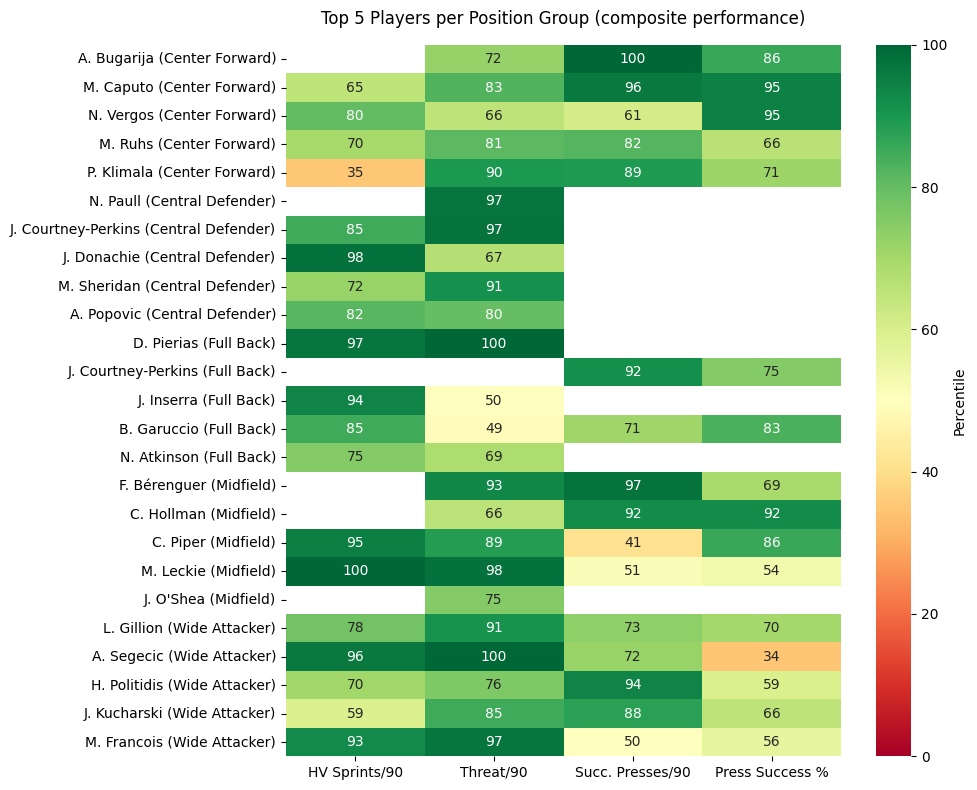


Showing top 5 players per position group (total: 25 players)


In [58]:
def build_performance_heatmap():
    """Heatmap showing top 5 players per position group based on composite performance."""
    
    # Use stricter filters for cleaner heatmap
    min_minutes = 60
    
    # Get players eligible for each metric family with their percentiles
    family_dfs = {}
    
    for family_name, cfg in METRIC_FAMILIES.items():
        eligible = get_eligible_players(df, family_name, min_minutes, cfg["min_volume_default"])
        eligible = add_percentiles(eligible, family_name, "Same position_group")
        
        # Aggregate to player level (mean across matches)
        pctile_cols = [m + '_pctile' for m in cfg["metrics"]]
        
        player_agg = eligible.groupby('player_id').agg({
            'player_short_name': 'first',
            'team_name': 'first',
            'position_group': 'first',
            **{col: 'mean' for col in pctile_cols}
        }).reset_index()
        
        family_dfs[family_name] = player_agg
    
    # Start with first family
    family_names = list(METRIC_FAMILIES.keys())
    combined = family_dfs[family_names[0]].copy()
    
    # Merge remaining families
    for family_name in family_names[1:]:
        combined = combined.merge(
            family_dfs[family_name],
            on=['player_id', 'player_short_name', 'team_name', 'position_group'],
            how='outer'
        )
    
    # Select key metrics for heatmap
    heatmap_metrics = {
        'high_value_sprints_per_90_pctile': 'HV Sprints/90',
        'threat_per_90_pctile': 'Threat/90',
        'successful_presses_per_90_pctile': 'Succ. Presses/90',
        'press_success_rate_pctile': 'Press Success %'
    }
    
    # Calculate composite score (mean of available metrics)
    combined['composite_score'] = combined[list(heatmap_metrics.keys())].mean(axis=1)
    
    # Get top 5 per position group
    top_players = (
        combined.groupby('position_group', group_keys=False)
        .apply(lambda x: x.nlargest(5, 'composite_score'))
        .reset_index(drop=True)
    )
    
    # Sort by position and composite score
    top_players = top_players.sort_values(['position_group', 'composite_score'], ascending=[True, False])
    
    # Build heatmap data (keep composite_score for reference but don't display)
    heatmap_cols = ['player_short_name', 'team_name', 'position_group'] + list(heatmap_metrics.keys())
    heatmap_data = top_players[heatmap_cols].dropna(subset=list(heatmap_metrics.keys()), how='all')
    
    # Rename columns for display
    heatmap_display = heatmap_data.copy()
    heatmap_display = heatmap_display.rename(columns=heatmap_metrics)
    
    # Plot
    fig, ax = plt.subplots(figsize=(10, max(8, len(heatmap_display) * 0.3)))
    
    sns.heatmap(
        heatmap_display[list(heatmap_metrics.values())],
        annot=True,
        fmt='.0f',
        cmap='RdYlGn',
        center=50,
        vmin=0,
        vmax=100,
        cbar_kws={'label': 'Percentile'},
        yticklabels=[f"{row['player_short_name']} ({row['position_group']})" 
                     for _, row in heatmap_data.iterrows()],
        ax=ax
    )
    
    ax.set_title('Top 5 Players per Position Group (composite performance)', fontsize=12, pad=15)
    plt.tight_layout()
    plt.show()
    
    return heatmap_data

print("=== Player Performance Heatmap ===\n")
heatmap_df = build_performance_heatmap()
print(f"\nShowing top 5 players per position group (total: {len(heatmap_df)} players)")